In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import torch
from utils import *
                
%load_ext autoreload
%autoreload 2

# Análisis de sentimientos: BOW

El primer modelo que vamos a usar para hacer análisis de sentimientos es el que aplicamos una codificación de "bolsa de palabras" (*Bag of Words* o *BOW*) y luego entrenamos un modelo feed-forward.

In [2]:
# Leemos y separamos en train / dev / test:
df_train, df_dev, df_test, vocab = read_and_split_dataset()
idx_to_tk = {idx: tk for idx, tk in enumerate(vocab)}
vocab_size = len(vocab)

# Tokenizamos:
samples = {}
unk_tk = '<UNK>'
unk_idx = vocab_size
for data, df in zip(['train', 'dev'],[df_train, df_dev]):
    samples[data] = tokenize_dataframe(df, vocab, unk_idx)

In [3]:
print('First train sample:')
print()
print('Comment:', [idx_to_tk.get(idx,unk_tk) for idx in samples['train'][0][0]])
print()
print('Rate:', samples['train'][0][1])
print()
print(df_train.head(1))

First train sample:

Comment: ['uk', 'newspaper', 'reviews', 'seem', 'to', 'have', 'concentrated', 'on', 'the', 'fact', 'that', 'the', 'reviewers', 'tend', 'to', 'know', 'toby', 'young', '<UNK>', 'the', 'journalist', 'on', 'whose', 'real-life', 'experiences', 'this', 'movie', 'is', 'based', '<UNK>', 'the', 'key', 'word', 'here', 'is', '<UNK>', 'based', '<UNK>', '<UNK>', 'how', 'to', 'lose', 'friends', 'is', 'a', 'fictitious', '<UNK>', '<UNK>', 'br', '<UNK>', '<UNK>', '<UNK>', 'br', '<UNK>', '<UNK>', 'sidney', 'young', 'joins', 'a', 'prestigious', 'gossip', 'magazine', 'in', 'new', 'york', '<UNK>', 'where', 'he', 'proceeds', 'to', 'make', 'gaffe', 'after', 'gaffe', 'before', 'finally', 'getting', 'it', 'right', 'and', 'making', 'it', '<UNK>', 'this', 'involves', 'him', 'selling', 'out', '<UNK>', 'and', 'the', 'movie', 'has', 'some', 'serious', 'points', 'to', 'make', 'about', 'journalistic', 'integrity', '<UNK>', 'however', '<UNK>', 'they', 'are', 'not', 'overdone', '<UNK>', 'the', 'mai

In [4]:
from torch.utils.data import Dataset, DataLoader

class IMDbDataset(Dataset):
    
    def __init__(self, samples, padding_idx=-1):
        
        num_samples = len(samples)
        lenghts = np.array([len(sample[0]) for sample in samples])
        max_len_idx = lenghts.max()
        self.x = torch.zeros(num_samples,max_len_idx, dtype=torch.long) + padding_idx
        for i, sample in enumerate(samples):
            self.x[i,:lenghts[i]] = torch.tensor(sample[0])
            
        self.y = torch.tensor([sample[1] for sample in samples], dtype=torch.float).view(-1,1)
        
    def __getitem__(self,idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return len(self.y)
    
padding_idx = vocab_size
train_dataset = IMDbDataset(samples['train'],padding_idx)
dev_dataset = IMDbDataset(samples['dev'], padding_idx)

batch_size = 512
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size, shuffle=True)

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class BOWModel(nn.Module):
    
    def __init__(self,vocab_size, padding_idx):
        super().__init__()
        self.emb = nn.Embedding(vocab_size+1,1,padding_idx)
        
    def forward(self,x):
        return self.emb(x).sum(dim=1)
    

model = BOWModel(vocab_size, padding_idx)
device = 'cuda:1'
BOWTrainer = Trainer(train_loader,dev_loader,model,device)

In [6]:
# Configuración del entrenamiento:
loss_fn = 'BCE'
optim_algorithm = 'Adam'
epochs = 1000
sample_loss_every = 10
check_on_train = False
learning_rate = 1e-4

BOWTrainer.train(loss_fn,optim_algorithm,epochs,sample_loss_every,check_on_train,lr=learning_rate)

Starting training...
Loss function: BCE
Optimization method: Adam
Learning Rate: 0.0001
Number of epochs: 1000
Running on device (cuda:1)

Epoch: 1, Batch number: 0, Loss: 28.379798889160156
Accuracy on validation dataset: 1987/5000 (39.74%)

Epoch: 1, Batch number: 10, Loss: 22.79421043395996
Accuracy on validation dataset: 2014/5000 (40.28%)

Epoch: 1, Batch number: 20, Loss: 22.97104263305664
Accuracy on validation dataset: 2042/5000 (40.84%)

Epoch: 1, Batch number: 30, Loss: 19.20479965209961
Accuracy on validation dataset: 2056/5000 (41.12%)

Epoch: 2, Batch number: 0, Loss: 18.076637268066406
Accuracy on validation dataset: 2069/5000 (41.38%)

Epoch: 2, Batch number: 10, Loss: 14.64228630065918
Accuracy on validation dataset: 2107/5000 (42.14%)

Epoch: 2, Batch number: 20, Loss: 16.23145294189453
Accuracy on validation dataset: 2134/5000 (42.68%)

Epoch: 2, Batch number: 30, Loss: 11.384954452514648
Accuracy on validation dataset: 2168/5000 (43.36%)

Epoch: 3, Batch number: 0, L

Accuracy on validation dataset: 2445/5000 (48.90%)

Epoch: 20, Batch number: 20, Loss: 2.5485777854919434
Accuracy on validation dataset: 2445/5000 (48.90%)

Epoch: 20, Batch number: 30, Loss: 4.266990661621094
Accuracy on validation dataset: 2447/5000 (48.94%)

Epoch: 21, Batch number: 0, Loss: 5.774154186248779
Accuracy on validation dataset: 2449/5000 (48.98%)

Epoch: 21, Batch number: 10, Loss: 3.272735118865967
Accuracy on validation dataset: 2449/5000 (48.98%)

Epoch: 21, Batch number: 20, Loss: 3.495983600616455
Accuracy on validation dataset: 2448/5000 (48.96%)

Epoch: 21, Batch number: 30, Loss: 2.9670443534851074
Accuracy on validation dataset: 2450/5000 (49.00%)

Epoch: 22, Batch number: 0, Loss: 2.206538200378418
Accuracy on validation dataset: 2451/5000 (49.02%)

Epoch: 22, Batch number: 10, Loss: -1.815572738647461
Accuracy on validation dataset: 2449/5000 (48.98%)

Epoch: 22, Batch number: 20, Loss: 1.9327762126922607
Accuracy on validation dataset: 2447/5000 (48.94%)

E

Accuracy on validation dataset: 2477/5000 (49.54%)

Epoch: 40, Batch number: 10, Loss: 1.1939773559570312
Accuracy on validation dataset: 2480/5000 (49.60%)

Epoch: 40, Batch number: 20, Loss: -1.3123369216918945
Accuracy on validation dataset: 2481/5000 (49.62%)

Epoch: 40, Batch number: 30, Loss: 2.1968231201171875
Accuracy on validation dataset: 2480/5000 (49.60%)

Epoch: 41, Batch number: 0, Loss: -0.38840585947036743
Accuracy on validation dataset: 2478/5000 (49.56%)

Epoch: 41, Batch number: 10, Loss: 4.865206718444824
Accuracy on validation dataset: 2481/5000 (49.62%)

Epoch: 41, Batch number: 20, Loss: 4.329229354858398
Accuracy on validation dataset: 2480/5000 (49.60%)

Epoch: 41, Batch number: 30, Loss: 3.147512197494507
Accuracy on validation dataset: 2481/5000 (49.62%)

Epoch: 42, Batch number: 0, Loss: -0.11015081405639648
Accuracy on validation dataset: 2479/5000 (49.58%)

Epoch: 42, Batch number: 10, Loss: 3.563987970352173
Accuracy on validation dataset: 2481/5000 (49.6

Accuracy on validation dataset: 2498/5000 (49.96%)

Epoch: 59, Batch number: 30, Loss: 1.2258458137512207
Accuracy on validation dataset: 2500/5000 (50.00%)

Epoch: 60, Batch number: 0, Loss: -0.8390757441520691
Accuracy on validation dataset: 2499/5000 (49.98%)

Epoch: 60, Batch number: 10, Loss: 4.024447917938232
Accuracy on validation dataset: 2500/5000 (50.00%)

Epoch: 60, Batch number: 20, Loss: 2.8559956550598145
Accuracy on validation dataset: 2500/5000 (50.00%)

Epoch: 60, Batch number: 30, Loss: 4.127842903137207
Accuracy on validation dataset: 2499/5000 (49.98%)

Epoch: 61, Batch number: 0, Loss: -1.8225538730621338
Accuracy on validation dataset: 2500/5000 (50.00%)

Epoch: 61, Batch number: 10, Loss: -0.06953215599060059
Accuracy on validation dataset: 2503/5000 (50.06%)

Epoch: 61, Batch number: 20, Loss: -0.6974320411682129
Accuracy on validation dataset: 2503/5000 (50.06%)

Epoch: 61, Batch number: 30, Loss: 1.2724984884262085
Accuracy on validation dataset: 2503/5000 (50

Epoch: 79, Batch number: 0, Loss: 3.889787435531616
Accuracy on validation dataset: 2530/5000 (50.60%)

Epoch: 79, Batch number: 10, Loss: 0.9507774114608765
Accuracy on validation dataset: 2527/5000 (50.54%)

Epoch: 79, Batch number: 20, Loss: 1.6933131217956543
Accuracy on validation dataset: 2525/5000 (50.50%)

Epoch: 79, Batch number: 30, Loss: 0.20184332132339478
Accuracy on validation dataset: 2527/5000 (50.54%)

Epoch: 80, Batch number: 0, Loss: -1.312361478805542
Accuracy on validation dataset: 2530/5000 (50.60%)

Epoch: 80, Batch number: 10, Loss: 4.312787055969238
Accuracy on validation dataset: 2530/5000 (50.60%)

Epoch: 80, Batch number: 20, Loss: -1.8870450258255005
Accuracy on validation dataset: 2531/5000 (50.62%)

Epoch: 80, Batch number: 30, Loss: 2.933365821838379
Accuracy on validation dataset: 2536/5000 (50.72%)

Epoch: 81, Batch number: 0, Loss: -0.3906062841415405
Accuracy on validation dataset: 2531/5000 (50.62%)

Epoch: 81, Batch number: 10, Loss: 2.010747432708

Accuracy on validation dataset: 2529/5000 (50.58%)

Epoch: 98, Batch number: 20, Loss: 4.437566757202148
Accuracy on validation dataset: 2530/5000 (50.60%)

Epoch: 98, Batch number: 30, Loss: 0.7534628510475159
Accuracy on validation dataset: 2534/5000 (50.68%)

Epoch: 99, Batch number: 0, Loss: 3.2562131881713867
Accuracy on validation dataset: 2535/5000 (50.70%)

Epoch: 99, Batch number: 10, Loss: 0.6276916265487671
Accuracy on validation dataset: 2533/5000 (50.66%)

Epoch: 99, Batch number: 20, Loss: 3.1839656829833984
Accuracy on validation dataset: 2538/5000 (50.76%)

Epoch: 99, Batch number: 30, Loss: 0.45388901233673096
Accuracy on validation dataset: 2534/5000 (50.68%)

Epoch: 100, Batch number: 0, Loss: -0.9619742035865784
Accuracy on validation dataset: 2535/5000 (50.70%)

Epoch: 100, Batch number: 10, Loss: 0.8677403330802917
Accuracy on validation dataset: 2534/5000 (50.68%)

Epoch: 100, Batch number: 20, Loss: -0.28310471773147583
Accuracy on validation dataset: 2536/5000 

Accuracy on validation dataset: 2561/5000 (51.22%)

Epoch: 117, Batch number: 30, Loss: -3.29583477973938
Accuracy on validation dataset: 2558/5000 (51.16%)

Epoch: 118, Batch number: 0, Loss: -1.9451005458831787
Accuracy on validation dataset: 2557/5000 (51.14%)

Epoch: 118, Batch number: 10, Loss: -1.015895128250122
Accuracy on validation dataset: 2559/5000 (51.18%)

Epoch: 118, Batch number: 20, Loss: -0.11584979295730591
Accuracy on validation dataset: 2562/5000 (51.24%)

Epoch: 118, Batch number: 30, Loss: 2.340975284576416
Accuracy on validation dataset: 2567/5000 (51.34%)

Epoch: 119, Batch number: 0, Loss: -2.948073387145996
Accuracy on validation dataset: 2562/5000 (51.24%)

Epoch: 119, Batch number: 10, Loss: 0.59828782081604
Accuracy on validation dataset: 2563/5000 (51.26%)

Epoch: 119, Batch number: 20, Loss: -0.46551135182380676
Accuracy on validation dataset: 2560/5000 (51.20%)

Epoch: 119, Batch number: 30, Loss: -3.379162311553955
Accuracy on validation dataset: 2560/5

Accuracy on validation dataset: 2603/5000 (52.06%)

Epoch: 137, Batch number: 0, Loss: -3.7657551765441895
Accuracy on validation dataset: 2604/5000 (52.08%)

Epoch: 137, Batch number: 10, Loss: -1.3522872924804688
Accuracy on validation dataset: 2599/5000 (51.98%)

Epoch: 137, Batch number: 20, Loss: -1.8462421894073486
Accuracy on validation dataset: 2597/5000 (51.94%)

Epoch: 137, Batch number: 30, Loss: -0.6594309210777283
Accuracy on validation dataset: 2600/5000 (52.00%)

Epoch: 138, Batch number: 0, Loss: -0.3859522342681885
Accuracy on validation dataset: 2599/5000 (51.98%)

Epoch: 138, Batch number: 10, Loss: -2.4281113147735596
Accuracy on validation dataset: 2597/5000 (51.94%)

Epoch: 138, Batch number: 20, Loss: -2.274648666381836
Accuracy on validation dataset: 2596/5000 (51.92%)

Epoch: 138, Batch number: 30, Loss: 0.7152220010757446
Accuracy on validation dataset: 2598/5000 (51.96%)

Epoch: 139, Batch number: 0, Loss: -3.229646921157837
Accuracy on validation dataset: 25

Epoch: 156, Batch number: 0, Loss: -4.504702091217041
Accuracy on validation dataset: 2604/5000 (52.08%)

Epoch: 156, Batch number: 10, Loss: -0.13321468234062195
Accuracy on validation dataset: 2605/5000 (52.10%)

Epoch: 156, Batch number: 20, Loss: -3.703688144683838
Accuracy on validation dataset: 2606/5000 (52.12%)

Epoch: 156, Batch number: 30, Loss: 1.5750305652618408
Accuracy on validation dataset: 2606/5000 (52.12%)

Epoch: 157, Batch number: 0, Loss: -0.22744014859199524
Accuracy on validation dataset: 2610/5000 (52.20%)

Epoch: 157, Batch number: 10, Loss: 2.270132541656494
Accuracy on validation dataset: 2607/5000 (52.14%)

Epoch: 157, Batch number: 20, Loss: -1.5218772888183594
Accuracy on validation dataset: 2606/5000 (52.12%)

Epoch: 157, Batch number: 30, Loss: 0.9660400748252869
Accuracy on validation dataset: 2607/5000 (52.14%)

Epoch: 158, Batch number: 0, Loss: -5.651867866516113
Accuracy on validation dataset: 2606/5000 (52.12%)

Epoch: 158, Batch number: 10, Loss: 

Accuracy on validation dataset: 2608/5000 (52.16%)

Epoch: 175, Batch number: 20, Loss: -5.889621257781982
Accuracy on validation dataset: 2610/5000 (52.20%)

Epoch: 175, Batch number: 30, Loss: -0.4288649559020996
Accuracy on validation dataset: 2610/5000 (52.20%)

Epoch: 176, Batch number: 0, Loss: -3.7224791049957275
Accuracy on validation dataset: 2606/5000 (52.12%)

Epoch: 176, Batch number: 10, Loss: 3.9738402366638184
Accuracy on validation dataset: 2608/5000 (52.16%)

Epoch: 176, Batch number: 20, Loss: -2.0121116638183594
Accuracy on validation dataset: 2608/5000 (52.16%)

Epoch: 176, Batch number: 30, Loss: -1.258175253868103
Accuracy on validation dataset: 2606/5000 (52.12%)

Epoch: 177, Batch number: 0, Loss: -3.7397429943084717
Accuracy on validation dataset: 2612/5000 (52.24%)

Epoch: 177, Batch number: 10, Loss: -0.8119609355926514
Accuracy on validation dataset: 2609/5000 (52.18%)

Epoch: 177, Batch number: 20, Loss: -6.684045791625977
Accuracy on validation dataset: 26

Epoch: 194, Batch number: 20, Loss: -1.4745533466339111
Accuracy on validation dataset: 2623/5000 (52.46%)

Epoch: 194, Batch number: 30, Loss: -3.6145126819610596
Accuracy on validation dataset: 2622/5000 (52.44%)

Epoch: 195, Batch number: 0, Loss: -1.1220695972442627
Accuracy on validation dataset: 2621/5000 (52.42%)

Epoch: 195, Batch number: 10, Loss: -1.6909701824188232
Accuracy on validation dataset: 2620/5000 (52.40%)

Epoch: 195, Batch number: 20, Loss: 3.595670223236084
Accuracy on validation dataset: 2620/5000 (52.40%)

Epoch: 195, Batch number: 30, Loss: -1.4810726642608643
Accuracy on validation dataset: 2621/5000 (52.42%)

Epoch: 196, Batch number: 0, Loss: -2.8369688987731934
Accuracy on validation dataset: 2624/5000 (52.48%)

Epoch: 196, Batch number: 10, Loss: -4.561244487762451
Accuracy on validation dataset: 2623/5000 (52.46%)

Epoch: 196, Batch number: 20, Loss: -2.418381929397583
Accuracy on validation dataset: 2621/5000 (52.42%)

Epoch: 196, Batch number: 30, Loss

Accuracy on validation dataset: 2628/5000 (52.56%)

Epoch: 214, Batch number: 0, Loss: -3.7360031604766846
Accuracy on validation dataset: 2636/5000 (52.72%)

Epoch: 214, Batch number: 10, Loss: -1.2254095077514648
Accuracy on validation dataset: 2638/5000 (52.76%)

Epoch: 214, Batch number: 20, Loss: -1.4608569145202637
Accuracy on validation dataset: 2628/5000 (52.56%)

Epoch: 214, Batch number: 30, Loss: -0.9001682996749878
Accuracy on validation dataset: 2631/5000 (52.62%)

Epoch: 215, Batch number: 0, Loss: -0.27189332246780396
Accuracy on validation dataset: 2631/5000 (52.62%)

Epoch: 215, Batch number: 10, Loss: -3.361515998840332
Accuracy on validation dataset: 2636/5000 (52.72%)

Epoch: 215, Batch number: 20, Loss: -0.8421528339385986
Accuracy on validation dataset: 2630/5000 (52.60%)

Epoch: 215, Batch number: 30, Loss: -1.206068992614746
Accuracy on validation dataset: 2632/5000 (52.64%)

Epoch: 216, Batch number: 0, Loss: 0.3181147575378418
Accuracy on validation dataset: 2

Epoch: 233, Batch number: 0, Loss: -6.093226909637451
Accuracy on validation dataset: 2638/5000 (52.76%)

Epoch: 233, Batch number: 10, Loss: -3.3313400745391846
Accuracy on validation dataset: 2640/5000 (52.80%)

Epoch: 233, Batch number: 20, Loss: -2.2053279876708984
Accuracy on validation dataset: 2642/5000 (52.84%)

Epoch: 233, Batch number: 30, Loss: -1.311643362045288
Accuracy on validation dataset: 2641/5000 (52.82%)

Epoch: 234, Batch number: 0, Loss: -3.4766159057617188
Accuracy on validation dataset: 2641/5000 (52.82%)

Epoch: 234, Batch number: 10, Loss: -9.623749732971191
Accuracy on validation dataset: 2642/5000 (52.84%)

Epoch: 234, Batch number: 20, Loss: -8.47927474975586
Accuracy on validation dataset: 2638/5000 (52.76%)

Epoch: 234, Batch number: 30, Loss: -7.288984298706055
Accuracy on validation dataset: 2642/5000 (52.84%)

Epoch: 235, Batch number: 0, Loss: -2.1492559909820557
Accuracy on validation dataset: 2640/5000 (52.80%)

Epoch: 235, Batch number: 10, Loss: -

Epoch: 252, Batch number: 20, Loss: -0.585487961769104
Accuracy on validation dataset: 2647/5000 (52.94%)

Epoch: 252, Batch number: 30, Loss: -4.115113258361816
Accuracy on validation dataset: 2645/5000 (52.90%)

Epoch: 253, Batch number: 0, Loss: -3.0499930381774902
Accuracy on validation dataset: 2649/5000 (52.98%)

Epoch: 253, Batch number: 10, Loss: -1.5501238107681274
Accuracy on validation dataset: 2649/5000 (52.98%)

Epoch: 253, Batch number: 20, Loss: -7.0030317306518555
Accuracy on validation dataset: 2649/5000 (52.98%)

Epoch: 253, Batch number: 30, Loss: -4.803979396820068
Accuracy on validation dataset: 2647/5000 (52.94%)

Epoch: 254, Batch number: 0, Loss: -2.054922103881836
Accuracy on validation dataset: 2649/5000 (52.98%)

Epoch: 254, Batch number: 10, Loss: -3.1621437072753906
Accuracy on validation dataset: 2649/5000 (52.98%)

Epoch: 254, Batch number: 20, Loss: -5.9536614418029785
Accuracy on validation dataset: 2649/5000 (52.98%)

Epoch: 254, Batch number: 30, Loss

Accuracy on validation dataset: 2654/5000 (53.08%)

Epoch: 272, Batch number: 0, Loss: -2.5774126052856445
Accuracy on validation dataset: 2652/5000 (53.04%)

Epoch: 272, Batch number: 10, Loss: -1.6514220237731934
Accuracy on validation dataset: 2652/5000 (53.04%)

Epoch: 272, Batch number: 20, Loss: -7.386448860168457
Accuracy on validation dataset: 2652/5000 (53.04%)

Epoch: 272, Batch number: 30, Loss: -0.9528871774673462
Accuracy on validation dataset: 2650/5000 (53.00%)

Epoch: 273, Batch number: 0, Loss: -5.810543537139893
Accuracy on validation dataset: 2655/5000 (53.10%)

Epoch: 273, Batch number: 10, Loss: -3.559393882751465
Accuracy on validation dataset: 2650/5000 (53.00%)

Epoch: 273, Batch number: 20, Loss: -5.468993186950684
Accuracy on validation dataset: 2657/5000 (53.14%)

Epoch: 273, Batch number: 30, Loss: -2.8770055770874023
Accuracy on validation dataset: 2661/5000 (53.22%)

Epoch: 274, Batch number: 0, Loss: -3.944744825363159
Accuracy on validation dataset: 2661

Epoch: 291, Batch number: 10, Loss: 0.5922538638114929
Accuracy on validation dataset: 2663/5000 (53.26%)

Epoch: 291, Batch number: 20, Loss: -8.709747314453125
Accuracy on validation dataset: 2661/5000 (53.22%)

Epoch: 291, Batch number: 30, Loss: -8.559797286987305
Accuracy on validation dataset: 2661/5000 (53.22%)

Epoch: 292, Batch number: 0, Loss: -5.308492660522461
Accuracy on validation dataset: 2663/5000 (53.26%)

Epoch: 292, Batch number: 10, Loss: -6.303084373474121
Accuracy on validation dataset: 2660/5000 (53.20%)

Epoch: 292, Batch number: 20, Loss: -5.715974807739258
Accuracy on validation dataset: 2663/5000 (53.26%)

Epoch: 292, Batch number: 30, Loss: -6.306519031524658
Accuracy on validation dataset: 2662/5000 (53.24%)

Epoch: 293, Batch number: 0, Loss: -5.4142656326293945
Accuracy on validation dataset: 2663/5000 (53.26%)

Epoch: 293, Batch number: 10, Loss: -4.795322418212891
Accuracy on validation dataset: 2663/5000 (53.26%)

Epoch: 293, Batch number: 20, Loss: -6

Accuracy on validation dataset: 2659/5000 (53.18%)

Epoch: 310, Batch number: 30, Loss: 1.5563055276870728
Accuracy on validation dataset: 2659/5000 (53.18%)

Epoch: 311, Batch number: 0, Loss: -7.9132585525512695
Accuracy on validation dataset: 2666/5000 (53.32%)

Epoch: 311, Batch number: 10, Loss: -2.7869296073913574
Accuracy on validation dataset: 2672/5000 (53.44%)

Epoch: 311, Batch number: 20, Loss: -8.065971374511719
Accuracy on validation dataset: 2672/5000 (53.44%)

Epoch: 311, Batch number: 30, Loss: -0.8185992240905762
Accuracy on validation dataset: 2668/5000 (53.36%)

Epoch: 312, Batch number: 0, Loss: -5.514883518218994
Accuracy on validation dataset: 2670/5000 (53.40%)

Epoch: 312, Batch number: 10, Loss: -2.55560040473938
Accuracy on validation dataset: 2668/5000 (53.36%)

Epoch: 312, Batch number: 20, Loss: 0.07756674289703369
Accuracy on validation dataset: 2666/5000 (53.32%)

Epoch: 312, Batch number: 30, Loss: -3.010658025741577
Accuracy on validation dataset: 2666

Accuracy on validation dataset: 2676/5000 (53.52%)

Epoch: 330, Batch number: 10, Loss: -11.53826904296875
Accuracy on validation dataset: 2668/5000 (53.36%)

Epoch: 330, Batch number: 20, Loss: -5.156656742095947
Accuracy on validation dataset: 2671/5000 (53.42%)

Epoch: 330, Batch number: 30, Loss: -1.3365367650985718
Accuracy on validation dataset: 2677/5000 (53.54%)

Epoch: 331, Batch number: 0, Loss: -2.752135753631592
Accuracy on validation dataset: 2677/5000 (53.54%)

Epoch: 331, Batch number: 10, Loss: -6.727360725402832
Accuracy on validation dataset: 2676/5000 (53.52%)

Epoch: 331, Batch number: 20, Loss: -0.8696436882019043
Accuracy on validation dataset: 2670/5000 (53.40%)

Epoch: 331, Batch number: 30, Loss: -6.647064685821533
Accuracy on validation dataset: 2668/5000 (53.36%)

Epoch: 332, Batch number: 0, Loss: -7.394252300262451
Accuracy on validation dataset: 2671/5000 (53.42%)

Epoch: 332, Batch number: 10, Loss: -2.7049193382263184
Accuracy on validation dataset: 2670

Epoch: 349, Batch number: 10, Loss: -4.150005340576172
Accuracy on validation dataset: 2680/5000 (53.60%)

Epoch: 349, Batch number: 20, Loss: -7.061807632446289
Accuracy on validation dataset: 2678/5000 (53.56%)

Epoch: 349, Batch number: 30, Loss: 2.999819040298462
Accuracy on validation dataset: 2675/5000 (53.50%)

Epoch: 350, Batch number: 0, Loss: -8.529742240905762
Accuracy on validation dataset: 2683/5000 (53.66%)

Epoch: 350, Batch number: 10, Loss: -10.323565483093262
Accuracy on validation dataset: 2682/5000 (53.64%)

Epoch: 350, Batch number: 20, Loss: -3.2295267581939697
Accuracy on validation dataset: 2678/5000 (53.56%)

Epoch: 350, Batch number: 30, Loss: -6.644319534301758
Accuracy on validation dataset: 2682/5000 (53.64%)

Epoch: 351, Batch number: 0, Loss: -8.963817596435547
Accuracy on validation dataset: 2683/5000 (53.66%)

Epoch: 351, Batch number: 10, Loss: -2.794999122619629
Accuracy on validation dataset: 2678/5000 (53.56%)

Epoch: 351, Batch number: 20, Loss: -1

Accuracy on validation dataset: 2690/5000 (53.80%)

Epoch: 368, Batch number: 30, Loss: -7.390758514404297
Accuracy on validation dataset: 2685/5000 (53.70%)

Epoch: 369, Batch number: 0, Loss: -10.725757598876953
Accuracy on validation dataset: 2689/5000 (53.78%)

Epoch: 369, Batch number: 10, Loss: -7.119657039642334
Accuracy on validation dataset: 2682/5000 (53.64%)

Epoch: 369, Batch number: 20, Loss: -0.8389730453491211
Accuracy on validation dataset: 2685/5000 (53.70%)

Epoch: 369, Batch number: 30, Loss: -8.523605346679688
Accuracy on validation dataset: 2685/5000 (53.70%)

Epoch: 370, Batch number: 0, Loss: -12.842182159423828
Accuracy on validation dataset: 2691/5000 (53.82%)

Epoch: 370, Batch number: 10, Loss: -3.72982120513916
Accuracy on validation dataset: 2689/5000 (53.78%)

Epoch: 370, Batch number: 20, Loss: -7.723345756530762
Accuracy on validation dataset: 2689/5000 (53.78%)

Epoch: 370, Batch number: 30, Loss: -2.3060429096221924
Accuracy on validation dataset: 2689

Accuracy on validation dataset: 2689/5000 (53.78%)

Epoch: 388, Batch number: 0, Loss: -4.454778671264648
Accuracy on validation dataset: 2690/5000 (53.80%)

Epoch: 388, Batch number: 10, Loss: -3.9462273120880127
Accuracy on validation dataset: 2689/5000 (53.78%)

Epoch: 388, Batch number: 20, Loss: -5.594101428985596
Accuracy on validation dataset: 2690/5000 (53.80%)

Epoch: 388, Batch number: 30, Loss: -10.504159927368164
Accuracy on validation dataset: 2689/5000 (53.78%)

Epoch: 389, Batch number: 0, Loss: -9.918237686157227
Accuracy on validation dataset: 2690/5000 (53.80%)

Epoch: 389, Batch number: 10, Loss: -8.785823822021484
Accuracy on validation dataset: 2692/5000 (53.84%)

Epoch: 389, Batch number: 20, Loss: -9.55094051361084
Accuracy on validation dataset: 2690/5000 (53.80%)

Epoch: 389, Batch number: 30, Loss: -7.0423583984375
Accuracy on validation dataset: 2692/5000 (53.84%)

Epoch: 390, Batch number: 0, Loss: -7.244338035583496
Accuracy on validation dataset: 2691/5000

Accuracy on validation dataset: 2697/5000 (53.94%)

Epoch: 407, Batch number: 10, Loss: -6.621433258056641
Accuracy on validation dataset: 2695/5000 (53.90%)

Epoch: 407, Batch number: 20, Loss: -6.873215675354004
Accuracy on validation dataset: 2697/5000 (53.94%)

Epoch: 407, Batch number: 30, Loss: -12.284295082092285
Accuracy on validation dataset: 2694/5000 (53.88%)

Epoch: 408, Batch number: 0, Loss: -4.566058158874512
Accuracy on validation dataset: 2693/5000 (53.86%)

Epoch: 408, Batch number: 10, Loss: -9.866827011108398
Accuracy on validation dataset: 2693/5000 (53.86%)

Epoch: 408, Batch number: 20, Loss: -14.487204551696777
Accuracy on validation dataset: 2695/5000 (53.90%)

Epoch: 408, Batch number: 30, Loss: -13.078852653503418
Accuracy on validation dataset: 2697/5000 (53.94%)

Epoch: 409, Batch number: 0, Loss: -7.5389556884765625
Accuracy on validation dataset: 2695/5000 (53.90%)

Epoch: 409, Batch number: 10, Loss: -2.7278778553009033
Accuracy on validation dataset: 26

Epoch: 426, Batch number: 10, Loss: -10.958477020263672
Accuracy on validation dataset: 2706/5000 (54.12%)

Epoch: 426, Batch number: 20, Loss: -6.57742977142334
Accuracy on validation dataset: 2712/5000 (54.24%)

Epoch: 426, Batch number: 30, Loss: -10.435868263244629
Accuracy on validation dataset: 2712/5000 (54.24%)

Epoch: 427, Batch number: 0, Loss: -5.341669082641602
Accuracy on validation dataset: 2703/5000 (54.06%)

Epoch: 427, Batch number: 10, Loss: -5.5587077140808105
Accuracy on validation dataset: 2698/5000 (53.96%)

Epoch: 427, Batch number: 20, Loss: -12.27737045288086
Accuracy on validation dataset: 2699/5000 (53.98%)

Epoch: 427, Batch number: 30, Loss: -6.033698558807373
Accuracy on validation dataset: 2699/5000 (53.98%)

Epoch: 428, Batch number: 0, Loss: -3.440847396850586
Accuracy on validation dataset: 2703/5000 (54.06%)

Epoch: 428, Batch number: 10, Loss: -7.0483245849609375
Accuracy on validation dataset: 2706/5000 (54.12%)

Epoch: 428, Batch number: 20, Loss: 

Epoch: 445, Batch number: 20, Loss: -7.62465763092041
Accuracy on validation dataset: 2712/5000 (54.24%)

Epoch: 445, Batch number: 30, Loss: -4.722651481628418
Accuracy on validation dataset: 2717/5000 (54.34%)

Epoch: 446, Batch number: 0, Loss: -9.085485458374023
Accuracy on validation dataset: 2712/5000 (54.24%)

Epoch: 446, Batch number: 10, Loss: -10.947067260742188
Accuracy on validation dataset: 2708/5000 (54.16%)

Epoch: 446, Batch number: 20, Loss: -2.7278289794921875
Accuracy on validation dataset: 2709/5000 (54.18%)

Epoch: 446, Batch number: 30, Loss: -8.318375587463379
Accuracy on validation dataset: 2708/5000 (54.16%)

Epoch: 447, Batch number: 0, Loss: -7.6440839767456055
Accuracy on validation dataset: 2712/5000 (54.24%)

Epoch: 447, Batch number: 10, Loss: -7.521111011505127
Accuracy on validation dataset: 2727/5000 (54.54%)

Epoch: 447, Batch number: 20, Loss: -4.695703506469727
Accuracy on validation dataset: 2727/5000 (54.54%)

Epoch: 447, Batch number: 30, Loss: -

Epoch: 464, Batch number: 30, Loss: -5.459523677825928
Accuracy on validation dataset: 2716/5000 (54.32%)

Epoch: 465, Batch number: 0, Loss: -6.451671600341797
Accuracy on validation dataset: 2719/5000 (54.38%)

Epoch: 465, Batch number: 10, Loss: -4.715240955352783
Accuracy on validation dataset: 2723/5000 (54.46%)

Epoch: 465, Batch number: 20, Loss: -13.474716186523438
Accuracy on validation dataset: 2723/5000 (54.46%)

Epoch: 465, Batch number: 30, Loss: -4.015758037567139
Accuracy on validation dataset: 2720/5000 (54.40%)

Epoch: 466, Batch number: 0, Loss: -6.338936805725098
Accuracy on validation dataset: 2720/5000 (54.40%)

Epoch: 466, Batch number: 10, Loss: -6.974081993103027
Accuracy on validation dataset: 2728/5000 (54.56%)

Epoch: 466, Batch number: 20, Loss: -11.499908447265625
Accuracy on validation dataset: 2729/5000 (54.58%)

Epoch: 466, Batch number: 30, Loss: -18.050525665283203
Accuracy on validation dataset: 2723/5000 (54.46%)

Epoch: 467, Batch number: 0, Loss: -

Accuracy on validation dataset: 2723/5000 (54.46%)

Epoch: 484, Batch number: 10, Loss: -7.730947971343994
Accuracy on validation dataset: 2724/5000 (54.48%)

Epoch: 484, Batch number: 20, Loss: -10.319435119628906
Accuracy on validation dataset: 2724/5000 (54.48%)

Epoch: 484, Batch number: 30, Loss: -13.549656867980957
Accuracy on validation dataset: 2728/5000 (54.56%)

Epoch: 485, Batch number: 0, Loss: -7.944026947021484
Accuracy on validation dataset: 2728/5000 (54.56%)

Epoch: 485, Batch number: 10, Loss: -5.965297698974609
Accuracy on validation dataset: 2729/5000 (54.58%)

Epoch: 485, Batch number: 20, Loss: -3.5478131771087646
Accuracy on validation dataset: 2730/5000 (54.60%)

Epoch: 485, Batch number: 30, Loss: 1.0883331298828125
Accuracy on validation dataset: 2730/5000 (54.60%)

Epoch: 486, Batch number: 0, Loss: -9.428180694580078
Accuracy on validation dataset: 2731/5000 (54.62%)

Epoch: 486, Batch number: 10, Loss: -8.603567123413086
Accuracy on validation dataset: 2732

Accuracy on validation dataset: 2727/5000 (54.54%)

Epoch: 503, Batch number: 30, Loss: -12.044164657592773
Accuracy on validation dataset: 2727/5000 (54.54%)

Epoch: 504, Batch number: 0, Loss: -14.341190338134766
Accuracy on validation dataset: 2726/5000 (54.52%)

Epoch: 504, Batch number: 10, Loss: -11.489994049072266
Accuracy on validation dataset: 2728/5000 (54.56%)

Epoch: 504, Batch number: 20, Loss: -16.796600341796875
Accuracy on validation dataset: 2727/5000 (54.54%)

Epoch: 504, Batch number: 30, Loss: -3.746105670928955
Accuracy on validation dataset: 2728/5000 (54.56%)

Epoch: 505, Batch number: 0, Loss: -10.068340301513672
Accuracy on validation dataset: 2728/5000 (54.56%)

Epoch: 505, Batch number: 10, Loss: -10.056571960449219
Accuracy on validation dataset: 2724/5000 (54.48%)

Epoch: 505, Batch number: 20, Loss: -7.114831924438477
Accuracy on validation dataset: 2725/5000 (54.50%)

Epoch: 505, Batch number: 30, Loss: -6.202394008636475
Accuracy on validation dataset: 2

Epoch: 522, Batch number: 30, Loss: -8.684303283691406
Accuracy on validation dataset: 2731/5000 (54.62%)

Epoch: 523, Batch number: 0, Loss: -10.431900024414062
Accuracy on validation dataset: 2735/5000 (54.70%)

Epoch: 523, Batch number: 10, Loss: -5.7018842697143555
Accuracy on validation dataset: 2735/5000 (54.70%)

Epoch: 523, Batch number: 20, Loss: -7.231415748596191
Accuracy on validation dataset: 2737/5000 (54.74%)

Epoch: 523, Batch number: 30, Loss: -12.483306884765625
Accuracy on validation dataset: 2738/5000 (54.76%)

Epoch: 524, Batch number: 0, Loss: -11.168364524841309
Accuracy on validation dataset: 2736/5000 (54.72%)

Epoch: 524, Batch number: 10, Loss: -7.850736141204834
Accuracy on validation dataset: 2736/5000 (54.72%)

Epoch: 524, Batch number: 20, Loss: -14.288784980773926
Accuracy on validation dataset: 2739/5000 (54.78%)

Epoch: 524, Batch number: 30, Loss: -13.805292129516602
Accuracy on validation dataset: 2731/5000 (54.62%)

Epoch: 525, Batch number: 0, Loss

Accuracy on validation dataset: 2743/5000 (54.86%)

Epoch: 542, Batch number: 10, Loss: -21.577598571777344
Accuracy on validation dataset: 2742/5000 (54.84%)

Epoch: 542, Batch number: 20, Loss: -7.630541801452637
Accuracy on validation dataset: 2743/5000 (54.86%)

Epoch: 542, Batch number: 30, Loss: -7.813669681549072
Accuracy on validation dataset: 2744/5000 (54.88%)

Epoch: 543, Batch number: 0, Loss: -10.120985984802246
Accuracy on validation dataset: 2733/5000 (54.66%)

Epoch: 543, Batch number: 10, Loss: -21.205673217773438
Accuracy on validation dataset: 2729/5000 (54.58%)

Epoch: 543, Batch number: 20, Loss: -7.861640930175781
Accuracy on validation dataset: 2729/5000 (54.58%)

Epoch: 543, Batch number: 30, Loss: -8.328218460083008
Accuracy on validation dataset: 2732/5000 (54.64%)

Epoch: 544, Batch number: 0, Loss: -10.982829093933105
Accuracy on validation dataset: 2733/5000 (54.66%)

Epoch: 544, Batch number: 10, Loss: -13.257214546203613
Accuracy on validation dataset: 27

Epoch: 561, Batch number: 20, Loss: -7.737799644470215
Accuracy on validation dataset: 2744/5000 (54.88%)

Epoch: 561, Batch number: 30, Loss: -8.554780006408691
Accuracy on validation dataset: 2745/5000 (54.90%)

Epoch: 562, Batch number: 0, Loss: -3.302382469177246
Accuracy on validation dataset: 2742/5000 (54.84%)

Epoch: 562, Batch number: 10, Loss: -11.893904685974121
Accuracy on validation dataset: 2737/5000 (54.74%)

Epoch: 562, Batch number: 20, Loss: -7.209746837615967
Accuracy on validation dataset: 2736/5000 (54.72%)

Epoch: 562, Batch number: 30, Loss: -2.270850419998169
Accuracy on validation dataset: 2747/5000 (54.94%)

Epoch: 563, Batch number: 0, Loss: -10.168587684631348
Accuracy on validation dataset: 2746/5000 (54.92%)

Epoch: 563, Batch number: 10, Loss: -4.8101019859313965
Accuracy on validation dataset: 2744/5000 (54.88%)

Epoch: 563, Batch number: 20, Loss: -16.724576950073242
Accuracy on validation dataset: 2736/5000 (54.72%)

Epoch: 563, Batch number: 30, Loss:

Epoch: 580, Batch number: 30, Loss: -14.00140380859375
Accuracy on validation dataset: 2741/5000 (54.82%)

Epoch: 581, Batch number: 0, Loss: -4.829139232635498
Accuracy on validation dataset: 2746/5000 (54.92%)

Epoch: 581, Batch number: 10, Loss: -9.349794387817383
Accuracy on validation dataset: 2748/5000 (54.96%)

Epoch: 581, Batch number: 20, Loss: -9.791568756103516
Accuracy on validation dataset: 2749/5000 (54.98%)

Epoch: 581, Batch number: 30, Loss: -21.072742462158203
Accuracy on validation dataset: 2748/5000 (54.96%)

Epoch: 582, Batch number: 0, Loss: -11.452247619628906
Accuracy on validation dataset: 2745/5000 (54.90%)

Epoch: 582, Batch number: 10, Loss: 0.12438303232192993
Accuracy on validation dataset: 2744/5000 (54.88%)

Epoch: 582, Batch number: 20, Loss: -2.315028190612793
Accuracy on validation dataset: 2743/5000 (54.86%)

Epoch: 582, Batch number: 30, Loss: -1.0666050910949707
Accuracy on validation dataset: 2742/5000 (54.84%)

Epoch: 583, Batch number: 0, Loss: 

Epoch: 600, Batch number: 0, Loss: -4.3905205726623535
Accuracy on validation dataset: 2747/5000 (54.94%)

Epoch: 600, Batch number: 10, Loss: -10.201927185058594
Accuracy on validation dataset: 2747/5000 (54.94%)

Epoch: 600, Batch number: 20, Loss: 2.122750759124756
Accuracy on validation dataset: 2750/5000 (55.00%)

Epoch: 600, Batch number: 30, Loss: -7.306737899780273
Accuracy on validation dataset: 2749/5000 (54.98%)

Epoch: 601, Batch number: 0, Loss: -7.425309658050537
Accuracy on validation dataset: 2747/5000 (54.94%)

Epoch: 601, Batch number: 10, Loss: -4.062208652496338
Accuracy on validation dataset: 2759/5000 (55.18%)

Epoch: 601, Batch number: 20, Loss: -11.650444984436035
Accuracy on validation dataset: 2760/5000 (55.20%)

Epoch: 601, Batch number: 30, Loss: -17.517391204833984
Accuracy on validation dataset: 2757/5000 (55.14%)

Epoch: 602, Batch number: 0, Loss: -16.308515548706055
Accuracy on validation dataset: 2751/5000 (55.02%)

Epoch: 602, Batch number: 10, Loss: 

Accuracy on validation dataset: 2750/5000 (55.00%)

Epoch: 619, Batch number: 10, Loss: -2.444270372390747
Accuracy on validation dataset: 2754/5000 (55.08%)

Epoch: 619, Batch number: 20, Loss: -19.30120849609375
Accuracy on validation dataset: 2750/5000 (55.00%)

Epoch: 619, Batch number: 30, Loss: -17.48580551147461
Accuracy on validation dataset: 2750/5000 (55.00%)

Epoch: 620, Batch number: 0, Loss: -10.196847915649414
Accuracy on validation dataset: 2752/5000 (55.04%)

Epoch: 620, Batch number: 10, Loss: -9.43681526184082
Accuracy on validation dataset: 2753/5000 (55.06%)

Epoch: 620, Batch number: 20, Loss: -8.969993591308594
Accuracy on validation dataset: 2754/5000 (55.08%)

Epoch: 620, Batch number: 30, Loss: -14.628312110900879
Accuracy on validation dataset: 2755/5000 (55.10%)

Epoch: 621, Batch number: 0, Loss: -7.909862518310547
Accuracy on validation dataset: 2751/5000 (55.02%)

Epoch: 621, Batch number: 10, Loss: -16.66094207763672
Accuracy on validation dataset: 2750/5

Epoch: 638, Batch number: 20, Loss: -11.80272102355957
Accuracy on validation dataset: 2750/5000 (55.00%)

Epoch: 638, Batch number: 30, Loss: -13.087130546569824
Accuracy on validation dataset: 2753/5000 (55.06%)

Epoch: 639, Batch number: 0, Loss: -8.776457786560059
Accuracy on validation dataset: 2751/5000 (55.02%)

Epoch: 639, Batch number: 10, Loss: -4.0387187004089355
Accuracy on validation dataset: 2753/5000 (55.06%)

Epoch: 639, Batch number: 20, Loss: -7.340271949768066
Accuracy on validation dataset: 2753/5000 (55.06%)

Epoch: 639, Batch number: 30, Loss: -15.05596923828125
Accuracy on validation dataset: 2754/5000 (55.08%)

Epoch: 640, Batch number: 0, Loss: -11.934465408325195
Accuracy on validation dataset: 2750/5000 (55.00%)

Epoch: 640, Batch number: 10, Loss: -14.450886726379395
Accuracy on validation dataset: 2751/5000 (55.02%)

Epoch: 640, Batch number: 20, Loss: -9.595200538635254
Accuracy on validation dataset: 2751/5000 (55.02%)

Epoch: 640, Batch number: 30, Loss:

Accuracy on validation dataset: 2757/5000 (55.14%)

Epoch: 657, Batch number: 30, Loss: -6.35249662399292
Accuracy on validation dataset: 2758/5000 (55.16%)

Epoch: 658, Batch number: 0, Loss: -19.760242462158203
Accuracy on validation dataset: 2756/5000 (55.12%)

Epoch: 658, Batch number: 10, Loss: -12.786371231079102
Accuracy on validation dataset: 2753/5000 (55.06%)

Epoch: 658, Batch number: 20, Loss: -12.389318466186523
Accuracy on validation dataset: 2754/5000 (55.08%)

Epoch: 658, Batch number: 30, Loss: 2.1288764476776123
Accuracy on validation dataset: 2752/5000 (55.04%)

Epoch: 659, Batch number: 0, Loss: -4.411099433898926
Accuracy on validation dataset: 2755/5000 (55.10%)

Epoch: 659, Batch number: 10, Loss: -18.389240264892578
Accuracy on validation dataset: 2756/5000 (55.12%)

Epoch: 659, Batch number: 20, Loss: -12.162952423095703
Accuracy on validation dataset: 2759/5000 (55.18%)

Epoch: 659, Batch number: 30, Loss: -14.811544418334961
Accuracy on validation dataset: 27

Epoch: 677, Batch number: 0, Loss: -4.617405891418457
Accuracy on validation dataset: 2757/5000 (55.14%)

Epoch: 677, Batch number: 10, Loss: -13.856138229370117
Accuracy on validation dataset: 2769/5000 (55.38%)

Epoch: 677, Batch number: 20, Loss: -7.7469401359558105
Accuracy on validation dataset: 2769/5000 (55.38%)

Epoch: 677, Batch number: 30, Loss: -15.496156692504883
Accuracy on validation dataset: 2764/5000 (55.28%)

Epoch: 678, Batch number: 0, Loss: -7.780247211456299
Accuracy on validation dataset: 2759/5000 (55.18%)

Epoch: 678, Batch number: 10, Loss: -7.328975677490234
Accuracy on validation dataset: 2756/5000 (55.12%)

Epoch: 678, Batch number: 20, Loss: -5.721120834350586
Accuracy on validation dataset: 2753/5000 (55.06%)

Epoch: 678, Batch number: 30, Loss: -11.254196166992188
Accuracy on validation dataset: 2756/5000 (55.12%)

Epoch: 679, Batch number: 0, Loss: -21.54099464416504
Accuracy on validation dataset: 2754/5000 (55.08%)

Epoch: 679, Batch number: 10, Loss: 

Accuracy on validation dataset: 2760/5000 (55.20%)

Epoch: 696, Batch number: 10, Loss: -14.956151962280273
Accuracy on validation dataset: 2754/5000 (55.08%)

Epoch: 696, Batch number: 20, Loss: -8.395224571228027
Accuracy on validation dataset: 2754/5000 (55.08%)

Epoch: 696, Batch number: 30, Loss: -12.856204986572266
Accuracy on validation dataset: 2754/5000 (55.08%)

Epoch: 697, Batch number: 0, Loss: -11.923229217529297
Accuracy on validation dataset: 2753/5000 (55.06%)

Epoch: 697, Batch number: 10, Loss: -7.80649471282959
Accuracy on validation dataset: 2755/5000 (55.10%)

Epoch: 697, Batch number: 20, Loss: -18.35144805908203
Accuracy on validation dataset: 2759/5000 (55.18%)

Epoch: 697, Batch number: 30, Loss: -3.787496566772461
Accuracy on validation dataset: 2758/5000 (55.16%)

Epoch: 698, Batch number: 0, Loss: -7.3827948570251465
Accuracy on validation dataset: 2759/5000 (55.18%)

Epoch: 698, Batch number: 10, Loss: -9.656149864196777
Accuracy on validation dataset: 2759

Epoch: 715, Batch number: 10, Loss: -8.904047966003418
Accuracy on validation dataset: 2764/5000 (55.28%)

Epoch: 715, Batch number: 20, Loss: -17.70454978942871
Accuracy on validation dataset: 2763/5000 (55.26%)

Epoch: 715, Batch number: 30, Loss: -18.074081420898438
Accuracy on validation dataset: 2763/5000 (55.26%)

Epoch: 716, Batch number: 0, Loss: -25.657337188720703
Accuracy on validation dataset: 2762/5000 (55.24%)

Epoch: 716, Batch number: 10, Loss: -28.0347900390625
Accuracy on validation dataset: 2760/5000 (55.20%)

Epoch: 716, Batch number: 20, Loss: -9.153654098510742
Accuracy on validation dataset: 2760/5000 (55.20%)

Epoch: 716, Batch number: 30, Loss: -9.86772346496582
Accuracy on validation dataset: 2761/5000 (55.22%)

Epoch: 717, Batch number: 0, Loss: -16.844783782958984
Accuracy on validation dataset: 2761/5000 (55.22%)

Epoch: 717, Batch number: 10, Loss: -8.886168479919434
Accuracy on validation dataset: 2770/5000 (55.40%)

Epoch: 717, Batch number: 20, Loss: -1

Accuracy on validation dataset: 2759/5000 (55.18%)

Epoch: 734, Batch number: 30, Loss: -7.69374942779541
Accuracy on validation dataset: 2758/5000 (55.16%)

Epoch: 735, Batch number: 0, Loss: -20.777053833007812
Accuracy on validation dataset: 2757/5000 (55.14%)

Epoch: 735, Batch number: 10, Loss: -15.28294563293457
Accuracy on validation dataset: 2761/5000 (55.22%)

Epoch: 735, Batch number: 20, Loss: -3.384129285812378
Accuracy on validation dataset: 2765/5000 (55.30%)

Epoch: 735, Batch number: 30, Loss: -3.4068470001220703
Accuracy on validation dataset: 2769/5000 (55.38%)

Epoch: 736, Batch number: 0, Loss: -15.468917846679688
Accuracy on validation dataset: 2767/5000 (55.34%)

Epoch: 736, Batch number: 10, Loss: -20.944293975830078
Accuracy on validation dataset: 2759/5000 (55.18%)

Epoch: 736, Batch number: 20, Loss: -6.889612197875977
Accuracy on validation dataset: 2759/5000 (55.18%)

Epoch: 736, Batch number: 30, Loss: -11.734582901000977
Accuracy on validation dataset: 276

Epoch: 754, Batch number: 0, Loss: -16.327651977539062
Accuracy on validation dataset: 2758/5000 (55.16%)

Epoch: 754, Batch number: 10, Loss: -7.819307327270508
Accuracy on validation dataset: 2764/5000 (55.28%)

Epoch: 754, Batch number: 20, Loss: -13.143945693969727
Accuracy on validation dataset: 2767/5000 (55.34%)

Epoch: 754, Batch number: 30, Loss: -17.28219985961914
Accuracy on validation dataset: 2764/5000 (55.28%)

Epoch: 755, Batch number: 0, Loss: -19.028846740722656
Accuracy on validation dataset: 2761/5000 (55.22%)

Epoch: 755, Batch number: 10, Loss: -11.299224853515625
Accuracy on validation dataset: 2757/5000 (55.14%)

Epoch: 755, Batch number: 20, Loss: -5.179126739501953
Accuracy on validation dataset: 2761/5000 (55.22%)

Epoch: 755, Batch number: 30, Loss: -15.799090385437012
Accuracy on validation dataset: 2758/5000 (55.16%)

Epoch: 756, Batch number: 0, Loss: -15.816186904907227
Accuracy on validation dataset: 2758/5000 (55.16%)

Epoch: 756, Batch number: 10, Loss

Accuracy on validation dataset: 2772/5000 (55.44%)

Epoch: 773, Batch number: 20, Loss: -12.4789457321167
Accuracy on validation dataset: 2770/5000 (55.40%)

Epoch: 773, Batch number: 30, Loss: -10.074363708496094
Accuracy on validation dataset: 2770/5000 (55.40%)

Epoch: 774, Batch number: 0, Loss: -24.384668350219727
Accuracy on validation dataset: 2767/5000 (55.34%)

Epoch: 774, Batch number: 10, Loss: -7.510756492614746
Accuracy on validation dataset: 2759/5000 (55.18%)

Epoch: 774, Batch number: 20, Loss: -11.827086448669434
Accuracy on validation dataset: 2759/5000 (55.18%)

Epoch: 774, Batch number: 30, Loss: -11.630844116210938
Accuracy on validation dataset: 2760/5000 (55.20%)

Epoch: 775, Batch number: 0, Loss: -18.232736587524414
Accuracy on validation dataset: 2758/5000 (55.16%)

Epoch: 775, Batch number: 10, Loss: -12.681486129760742
Accuracy on validation dataset: 2760/5000 (55.20%)

Epoch: 775, Batch number: 20, Loss: -13.673677444458008
Accuracy on validation dataset: 2

Epoch: 792, Batch number: 20, Loss: -24.269603729248047
Accuracy on validation dataset: 2759/5000 (55.18%)

Epoch: 792, Batch number: 30, Loss: -5.877216339111328
Accuracy on validation dataset: 2760/5000 (55.20%)

Epoch: 793, Batch number: 0, Loss: -8.870473861694336
Accuracy on validation dataset: 2761/5000 (55.22%)

Epoch: 793, Batch number: 10, Loss: -15.668730735778809
Accuracy on validation dataset: 2775/5000 (55.50%)

Epoch: 793, Batch number: 20, Loss: -26.81136703491211
Accuracy on validation dataset: 2774/5000 (55.48%)

Epoch: 793, Batch number: 30, Loss: -15.032073974609375
Accuracy on validation dataset: 2773/5000 (55.46%)

Epoch: 794, Batch number: 0, Loss: -19.27568817138672
Accuracy on validation dataset: 2772/5000 (55.44%)

Epoch: 794, Batch number: 10, Loss: -11.865228652954102
Accuracy on validation dataset: 2768/5000 (55.36%)

Epoch: 794, Batch number: 20, Loss: -10.867471694946289
Accuracy on validation dataset: 2763/5000 (55.26%)

Epoch: 794, Batch number: 30, Loss

Accuracy on validation dataset: 2773/5000 (55.46%)

Epoch: 811, Batch number: 30, Loss: -17.90296173095703
Accuracy on validation dataset: 2775/5000 (55.50%)

Epoch: 812, Batch number: 0, Loss: -20.644460678100586
Accuracy on validation dataset: 2770/5000 (55.40%)

Epoch: 812, Batch number: 10, Loss: -14.626876831054688
Accuracy on validation dataset: 2766/5000 (55.32%)

Epoch: 812, Batch number: 20, Loss: -9.301471710205078
Accuracy on validation dataset: 2763/5000 (55.26%)

Epoch: 812, Batch number: 30, Loss: -4.13145112991333
Accuracy on validation dataset: 2764/5000 (55.28%)

Epoch: 813, Batch number: 0, Loss: -9.100492477416992
Accuracy on validation dataset: 2771/5000 (55.42%)

Epoch: 813, Batch number: 10, Loss: -18.06719207763672
Accuracy on validation dataset: 2776/5000 (55.52%)

Epoch: 813, Batch number: 20, Loss: -16.929107666015625
Accuracy on validation dataset: 2775/5000 (55.50%)

Epoch: 813, Batch number: 30, Loss: -7.360528945922852
Accuracy on validation dataset: 2771/

Epoch: 831, Batch number: 0, Loss: -18.25103759765625
Accuracy on validation dataset: 2765/5000 (55.30%)

Epoch: 831, Batch number: 10, Loss: -18.001737594604492
Accuracy on validation dataset: 2765/5000 (55.30%)

Epoch: 831, Batch number: 20, Loss: -17.88726234436035
Accuracy on validation dataset: 2768/5000 (55.36%)

Epoch: 831, Batch number: 30, Loss: -13.610689163208008
Accuracy on validation dataset: 2771/5000 (55.42%)

Epoch: 832, Batch number: 0, Loss: -8.519283294677734
Accuracy on validation dataset: 2770/5000 (55.40%)

Epoch: 832, Batch number: 10, Loss: -6.151271343231201
Accuracy on validation dataset: 2773/5000 (55.46%)

Epoch: 832, Batch number: 20, Loss: -17.710403442382812
Accuracy on validation dataset: 2775/5000 (55.50%)

Epoch: 832, Batch number: 30, Loss: -17.15143585205078
Accuracy on validation dataset: 2771/5000 (55.42%)

Epoch: 833, Batch number: 0, Loss: -14.661203384399414
Accuracy on validation dataset: 2773/5000 (55.46%)

Epoch: 833, Batch number: 10, Loss: 

Epoch: 850, Batch number: 10, Loss: -5.869997024536133
Accuracy on validation dataset: 2766/5000 (55.32%)

Epoch: 850, Batch number: 20, Loss: -20.199127197265625
Accuracy on validation dataset: 2770/5000 (55.40%)

Epoch: 850, Batch number: 30, Loss: -14.321059226989746
Accuracy on validation dataset: 2771/5000 (55.42%)

Epoch: 851, Batch number: 0, Loss: -26.541282653808594
Accuracy on validation dataset: 2771/5000 (55.42%)

Epoch: 851, Batch number: 10, Loss: -20.994998931884766
Accuracy on validation dataset: 2771/5000 (55.42%)

Epoch: 851, Batch number: 20, Loss: -19.0809326171875
Accuracy on validation dataset: 2770/5000 (55.40%)

Epoch: 851, Batch number: 30, Loss: -16.56268310546875
Accuracy on validation dataset: 2771/5000 (55.42%)

Epoch: 852, Batch number: 0, Loss: -12.058338165283203
Accuracy on validation dataset: 2770/5000 (55.40%)

Epoch: 852, Batch number: 10, Loss: -14.691272735595703
Accuracy on validation dataset: 2770/5000 (55.40%)

Epoch: 852, Batch number: 20, Loss

Epoch: 869, Batch number: 20, Loss: -22.322099685668945
Accuracy on validation dataset: 2781/5000 (55.62%)

Epoch: 869, Batch number: 30, Loss: -7.626275539398193
Accuracy on validation dataset: 2771/5000 (55.42%)

Epoch: 870, Batch number: 0, Loss: -13.495798110961914
Accuracy on validation dataset: 2772/5000 (55.44%)

Epoch: 870, Batch number: 10, Loss: -21.481996536254883
Accuracy on validation dataset: 2771/5000 (55.42%)

Epoch: 870, Batch number: 20, Loss: -16.570232391357422
Accuracy on validation dataset: 2771/5000 (55.42%)

Epoch: 870, Batch number: 30, Loss: -17.549949645996094
Accuracy on validation dataset: 2778/5000 (55.56%)

Epoch: 871, Batch number: 0, Loss: -9.29802131652832
Accuracy on validation dataset: 2777/5000 (55.54%)

Epoch: 871, Batch number: 10, Loss: -14.660345077514648
Accuracy on validation dataset: 2777/5000 (55.54%)

Epoch: 871, Batch number: 20, Loss: -21.19222640991211
Accuracy on validation dataset: 2778/5000 (55.56%)

Epoch: 871, Batch number: 30, Loss

Accuracy on validation dataset: 2773/5000 (55.46%)

Epoch: 888, Batch number: 30, Loss: -15.366578102111816
Accuracy on validation dataset: 2777/5000 (55.54%)

Epoch: 889, Batch number: 0, Loss: -19.83506202697754
Accuracy on validation dataset: 2774/5000 (55.48%)

Epoch: 889, Batch number: 10, Loss: -8.349370002746582
Accuracy on validation dataset: 2775/5000 (55.50%)

Epoch: 889, Batch number: 20, Loss: -11.525513648986816
Accuracy on validation dataset: 2774/5000 (55.48%)

Epoch: 889, Batch number: 30, Loss: -11.736371994018555
Accuracy on validation dataset: 2775/5000 (55.50%)

Epoch: 890, Batch number: 0, Loss: -10.458749771118164
Accuracy on validation dataset: 2776/5000 (55.52%)

Epoch: 890, Batch number: 10, Loss: -15.241327285766602
Accuracy on validation dataset: 2775/5000 (55.50%)

Epoch: 890, Batch number: 20, Loss: -22.17908477783203
Accuracy on validation dataset: 2775/5000 (55.50%)

Epoch: 890, Batch number: 30, Loss: -16.716636657714844
Accuracy on validation dataset: 2

Accuracy on validation dataset: 2772/5000 (55.44%)

Epoch: 908, Batch number: 0, Loss: -28.337718963623047
Accuracy on validation dataset: 2772/5000 (55.44%)

Epoch: 908, Batch number: 10, Loss: -12.609823226928711
Accuracy on validation dataset: 2767/5000 (55.34%)

Epoch: 908, Batch number: 20, Loss: -15.211795806884766
Accuracy on validation dataset: 2768/5000 (55.36%)

Epoch: 908, Batch number: 30, Loss: -13.016263008117676
Accuracy on validation dataset: 2766/5000 (55.32%)

Epoch: 909, Batch number: 0, Loss: -12.888343811035156
Accuracy on validation dataset: 2772/5000 (55.44%)

Epoch: 909, Batch number: 10, Loss: -15.530801773071289
Accuracy on validation dataset: 2776/5000 (55.52%)

Epoch: 909, Batch number: 20, Loss: -28.67412757873535
Accuracy on validation dataset: 2775/5000 (55.50%)

Epoch: 909, Batch number: 30, Loss: -20.87481689453125
Accuracy on validation dataset: 2776/5000 (55.52%)

Epoch: 910, Batch number: 0, Loss: -8.944527626037598
Accuracy on validation dataset: 27

Accuracy on validation dataset: 2781/5000 (55.62%)

Epoch: 927, Batch number: 10, Loss: -16.481304168701172
Accuracy on validation dataset: 2777/5000 (55.54%)

Epoch: 927, Batch number: 20, Loss: -11.99410343170166
Accuracy on validation dataset: 2777/5000 (55.54%)

Epoch: 927, Batch number: 30, Loss: -7.296347618103027
Accuracy on validation dataset: 2778/5000 (55.56%)

Epoch: 928, Batch number: 0, Loss: -26.289501190185547
Accuracy on validation dataset: 2776/5000 (55.52%)

Epoch: 928, Batch number: 10, Loss: -33.237430572509766
Accuracy on validation dataset: 2778/5000 (55.56%)

Epoch: 928, Batch number: 20, Loss: -20.837249755859375
Accuracy on validation dataset: 2777/5000 (55.54%)

Epoch: 928, Batch number: 30, Loss: -2.3347978591918945
Accuracy on validation dataset: 2776/5000 (55.52%)

Epoch: 929, Batch number: 0, Loss: -19.653810501098633
Accuracy on validation dataset: 2779/5000 (55.58%)

Epoch: 929, Batch number: 10, Loss: -15.247024536132812
Accuracy on validation dataset: 

Epoch: 946, Batch number: 20, Loss: -26.37126350402832
Accuracy on validation dataset: 2778/5000 (55.56%)

Epoch: 946, Batch number: 30, Loss: -15.842815399169922
Accuracy on validation dataset: 2778/5000 (55.56%)

Epoch: 947, Batch number: 0, Loss: -6.841365814208984
Accuracy on validation dataset: 2777/5000 (55.54%)

Epoch: 947, Batch number: 10, Loss: -5.75093936920166
Accuracy on validation dataset: 2775/5000 (55.50%)

Epoch: 947, Batch number: 20, Loss: -9.176857948303223
Accuracy on validation dataset: 2773/5000 (55.46%)

Epoch: 947, Batch number: 30, Loss: -15.742238998413086
Accuracy on validation dataset: 2774/5000 (55.48%)

Epoch: 948, Batch number: 0, Loss: -11.503710746765137
Accuracy on validation dataset: 2775/5000 (55.50%)

Epoch: 948, Batch number: 10, Loss: -17.601104736328125
Accuracy on validation dataset: 2778/5000 (55.56%)

Epoch: 948, Batch number: 20, Loss: -10.756357192993164
Accuracy on validation dataset: 2778/5000 (55.56%)

Epoch: 948, Batch number: 30, Loss:

Accuracy on validation dataset: 2767/5000 (55.34%)

Epoch: 965, Batch number: 30, Loss: -27.736902236938477
Accuracy on validation dataset: 2771/5000 (55.42%)

Epoch: 966, Batch number: 0, Loss: -12.025981903076172
Accuracy on validation dataset: 2770/5000 (55.40%)

Epoch: 966, Batch number: 10, Loss: -19.89296531677246
Accuracy on validation dataset: 2782/5000 (55.64%)

Epoch: 966, Batch number: 20, Loss: -14.153780937194824
Accuracy on validation dataset: 2782/5000 (55.64%)

Epoch: 966, Batch number: 30, Loss: -13.899795532226562
Accuracy on validation dataset: 2783/5000 (55.66%)

Epoch: 967, Batch number: 0, Loss: -17.462322235107422
Accuracy on validation dataset: 2783/5000 (55.66%)

Epoch: 967, Batch number: 10, Loss: -10.11060905456543
Accuracy on validation dataset: 2782/5000 (55.64%)

Epoch: 967, Batch number: 20, Loss: -20.824871063232422
Accuracy on validation dataset: 2782/5000 (55.64%)

Epoch: 967, Batch number: 30, Loss: -30.209712982177734
Accuracy on validation dataset: 

Epoch: 984, Batch number: 30, Loss: -16.9040470123291
Accuracy on validation dataset: 2782/5000 (55.64%)

Epoch: 985, Batch number: 0, Loss: -21.0787296295166
Accuracy on validation dataset: 2780/5000 (55.60%)

Epoch: 985, Batch number: 10, Loss: -14.94754409790039
Accuracy on validation dataset: 2780/5000 (55.60%)

Epoch: 985, Batch number: 20, Loss: -16.42005729675293
Accuracy on validation dataset: 2783/5000 (55.66%)

Epoch: 985, Batch number: 30, Loss: -20.11993408203125
Accuracy on validation dataset: 2780/5000 (55.60%)

Epoch: 986, Batch number: 0, Loss: -15.602879524230957
Accuracy on validation dataset: 2778/5000 (55.56%)

Epoch: 986, Batch number: 10, Loss: -25.835289001464844
Accuracy on validation dataset: 2778/5000 (55.56%)

Epoch: 986, Batch number: 20, Loss: -21.414514541625977
Accuracy on validation dataset: 2778/5000 (55.56%)

Epoch: 986, Batch number: 30, Loss: -16.986492156982422
Accuracy on validation dataset: 2776/5000 (55.52%)

Epoch: 987, Batch number: 0, Loss: -1

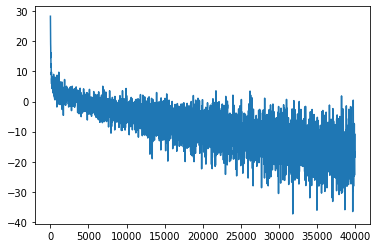

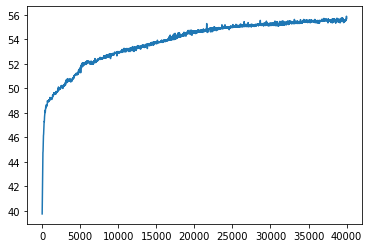

In [7]:
BOWTrainer.plot_history()

# TO DO:

* El primer método de análisis de sentimientos se basa en los métodos de machine learning clásicos para clasificación, en suma con la representación BOW de un texto. Esto es lo que se va a explicar en este notebook.

* Primero, modelos discriminativos. Generalized linear models y Logistic Regression con maximum likelihood. Entrenamiento por gradiente descendiente y por el método de newton (ver curso de cs229). Término de regularización (ver cap 5 de jurafky martin).

* Después, métodos generativos. Naive Bayes y Max entropy. Ver cap 4 del jurafsky martin y el tutorial de cs224u de sentiment analysis.

* Discussion del método BOW. Otras formas de extracción de features. Sentiment aware tokenization. Ver tutorial cs224u.

* Discussion sobre la utilización de otros datasets. 

* Sentiment Treebank iría acá? Investigar...